# Overview of Week 3

This week's assignment consists of two parts. The first part gives you an introduction to unsupervised learning. In particular, we focus on techniques for clustering and dimensionality reduction and how they can be applied to ecommerce data. As you work through the three clustering case studies, you will find yourself generating many intermediate datasets, trying different models, and tuning each model as you go along. There's a lot to keep track of.   

This is where Part 2 comes in. It is in Part 2 that we introduce ideas of **workflow management** and **computational reproducibility**. Workflow management means organising your project directory to manage your analysis' artefacts (visualisations, processed datasets, notebooks and utility functions and experiment results). Ideally, your code for these should be clearly commented with well chosen names. Computational reproducibility means someone else (including future you!) being able to take just the code and data, and reproduce your project, from its results and models to visualisations etc. How one decides to practice workflow management and computational reproducibility can be quite a personal decision. Therefore, we provide guidelines, not rules. The most important is having a system rather than no system at all. 

**note about the week**   
While week 1's assignment was guided, with specific instructions about what code to run, as we move on the assignments will involve less hand-holding. For this week, we include some instructions, but leave the specific implementations up to you. There are also many techniques we cover. Again, while we share some resources, we leave the bulk of the research and background reading up to you to manage for yourself. As a record of how well you have synthesised your readings, this notebook has space for writing a few paragraphs of explanations. We hope you won't be content with a shallow explanation, and that you use this space to apply the [Feynmann technique](https://collegeinfogeek.com/feynman-technique/) as a check of understanding. 

To tie Part 1 and Part 2 of the week together, we are not just asking for one Jupyter Notebook as a final deliverable. Instead, there are four deliverables to the week: 

**1. Part 1 Notebook I and II exercises presented at the end of the week job-interview style**

**2. A script that automates the data cleaning and feature engineering steps you take so your findings are reproducible (see Part 2 Notebook I for more info)**

**3. A repo README.md (see Part 2 Notebook I for more info)**

**4  A record of software package versions and software environment used (see Part 2 Notebook I for more info)**   

**recap of the objectives for the first 6 weeks:**  
We aim to broadly cover a wide range of Machine Learning algorithms so that you can: 
- handle the technical demands of a 100E given some guidance on the right direction to take 
- can handle a technical job interview and get hired 

*materials for unsupervised learning adapted from William Thji* 

# Part I : Unsupervised Learning 
Unsupervised Learning refers to a set of machine learning techniques where no output variables (Y) are given. Only the input variables (X) are available and our job is to find patterns in X. You may read more about it from *pg 485 from Hastie and Tibshirani's Elements of Statistical Learning* available [here](https://web.stanford.edu/~hastie/Papers/ESLII.pdf). 

ESL by Hastie et. al with be the primary reference for this week, although feel free to source for your own books and links. 

## Short introduction to clustering 
Clustering puts datapoints into subsets so that datapoints within a cluster are more closely related to one another compared to datapoints in another cluster. More information is available from page 501 of *Elements of Statistical Learning*. 

Some quick points: 
- Clustering is extremely useful to many fields: 
    - Customer segmentation for personalised product recommendations
    - Topic identification to relieve the need to manually vet documents 
    - Image or geo-spatial segmentation to optimised supply and demand (Gojek does this) 
    - and maybe most importantly, getting a sense of the data before starting to model it. 

- Some examples of clustering algorithms: 
    - KMeans
    - Gaussian Mixture Models for drawing soft clustering boundaries instead of hard ones 
    - Hierarchical clustering
    - DBScan for density-based clustering for anomaly detection 
    - Co-clustering
    - Biclustering for analysing genes

## Deliverable 1: Complete the Clustering Case Study: Using PCA and clustering to uncover customer segments 
Context: The dataset we will be working with contains ecommerce transactions from a UK-based online retails store. The dataset is available on [Kaggle](https://www.kaggle.com/carrie1/ecommerce-data/home) or the UCI Machine Learning Repository. The dataset is quite small, so we have also included it inside the `data` folder inside this repo as `data/raw/data.csv`. 

From the Kaggle website: 

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

### Case Study Goal 
Cluster the dataset into meaningful customer segments. This means creating clusters that are statistically robust and that make business sense. 


In [16]:
import pandas as pd 
import numpy as np
import copy
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.stats import ttest_ind as ttest
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.decomposition import PCA

from src.preprocessing import Cleaning
from src.preprocessing import FeatEng

In [17]:
df = pd.read_csv('data/raw/data.csv', encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Cleaning data 

Some data types are muddled, there are duplicates, NA values and unreasonable values hiding in the columns 

1. Clean the dataset. You may want to list the steps taken to clean the data and encapsulate the steps inside their own functions so they can be reused. Organise the functions into their own library

In [18]:
pre = Cleaning()
# NA values
df = pre.remove_na(df)
#check for duplicates
df =pre.drop_dup(df)
#check for unreasonable values
df = pre.remove_nonpos(df,['Quantity','UnitPrice'])
df = pre.remove_nonint(df,['CustomerID'])
#check data type
pre.check_dtype(df)
df = pre.change_dtype(df,['InvoiceNo','CustomerID'],'int')
df = pre.change_dtype(df,['InvoiceDate'],'datetime',"%m/%d/%Y %H:%M")
pre.check_dtype(df)

df.shape

Number of Na values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Number of duplicated rows: 5225

Non-positive values in Quantity : 8872 rows

Non-positive values in UnitPrice : 40 rows

Non-integer values in CustomerID : 0 rows

Feature Data Types: 
InvoiceNo <class 'str'>
StockCode <class 'str'>
Description <class 'str'>
Quantity <class 'numpy.int64'>
InvoiceDate <class 'str'>
UnitPrice <class 'numpy.float64'>
CustomerID <class 'numpy.float64'>
Country <class 'str'>

Changed InvoiceNo to integer type

Changed CustomerID to integer type

Changed InvoiceDate to datetime type

Feature Data Types: 
InvoiceNo <class 'numpy.int64'>
StockCode <class 'str'>
Description <class 'str'>
Quantity <class 'numpy.int64'>
InvoiceDate <class 'pandas._libs.tslibs.timestamps.Timestamp'>
UnitPrice <class 'numpy.float64'>
CustomerID <class 'numpy.int64'>
Country

(392692, 8)

In [19]:
#df.to_csv('data/derived/data2.csv',index=False)

### Feature Engineering iteration #1 

Inside the dataset, each row contains information about an ecommerce transation. However, we want to cluster the data by customers, which means each row should instead contain information about a customer. 

1. Reshape the data to follow the format below: 
![alt text](customer.png)

The dataframe should have these columns: `['NoOfInvoices', 'NoOfUniqueItems', 'QuantityPerInvoice', 'TotalQuantity', 'UniqueItemsPerInvoice','UnitPriceMean','UnitPriceStd']` 
2. Save this dataset as an intermediate dataset 

In [20]:
eng = FeatEng()
df2 = eng.features(df)
df2.head()

,NoOfInvoices,NoOfUniqueItems,QuantityPerInvoice,SpendingPerInvoice,TotalQuantity,UniqueItemsPerInvoice,UnitPriceMean,UnitPriceStd
CustomerID,,,,,,,,
12346,1,1,74215.000000,77183.600000,1,1.000000,1.040000,NaN
12347,7,103,351.142857,615.714286,182,14.714286,2.644011,2.255381
12348,4,22,585.250000,525.390000,31,5.500000,6.618889,14.191385
12349,1,73,631.000000,1757.550000,73,73.000000,8.289041,35.028021
12350,1,17,197.000000,334.400000,17,17.000000,3.841176,9.334751


In [21]:
df2 =df2.dropna()
df2.shape

(4266, 8)

### Hierarchical clustering iteration #1 [reference pg 520](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)

1. Implement any more preprocessing or visualisation steps you feel are necessary to understand how you might build meaningful clusters from the data. 
2. Apply hierarchical clustering to the dataset. 
2. Experiment with different linkage algorithms. Visualise the resulting trees for average linkage, complete linkage and single linkage side-by-side. Which linkage algorithm works best? 
3. List two ways to improve the clustering and implement at least one. Track the results of the first iteration and second iteration (whether with Excel, TextEdit or within this notebook itself). 
4. Describe the clusters you selected and evaluate whether or not they form meaningful segments. 

### Preprocessing

In [22]:
df2.describe()

,NoOfInvoices,NoOfUniqueItems,QuantityPerInvoice,SpendingPerInvoice,TotalQuantity,UniqueItemsPerInvoice,UnitPriceMean,UnitPriceStd
count,4266.000000,4266.000000,4266.000000,4266.000000,4266.000000,4266.000000,4266.000000,4266.000000
mean,4.327239,62.522269,236.072674,406.616408,92.034459,18.991617,3.732843,4.473929
std,7.750856,85.718570,681.231260,1378.186344,227.099847,17.154460,10.931120,19.729048
min,1.000000,1.000000,1.000000,3.450000,2.000000,0.200000,0.122500,0.000000
25%,1.000000,17.000000,93.562500,183.046667,18.000000,8.000000,2.247515,1.829769
50%,2.000000,36.000000,162.166667,298.025000,42.000000,14.333333,2.953301,2.651637
75%,5.000000,79.000000,271.125000,436.150000,100.000000,24.000000,3.842169,3.608881
max,209.000000,1787.000000,40498.500000,84236.250000,7676.000000,219.000000,434.650000,602.440835


In [23]:
#Outlier removal by mean2+std dev
#removal on one side as lower bound bounded at zero (3*std > mean for all columns anyway)

df3 = df2
max_val = (np.mean(df2) + 2*np.std(df2)).tolist()
for i in range(df3.shape[1]):
    df3 = df3.loc[df3.iloc[:,i]<=max_val[i],:]
df3.shape    

(3832, 8)

In [24]:
#Scaling df3 to mean = 0 and std dev =1
scaler = StandardScaler()
scaler.fit(df3.values)
df4 = scaler.transform(df3.values)

In [10]:
#pd.DataFrame(df4,columns = df2.columns).to_csv('data/derived/data4.csv',index=False)

### Hierarchical Clustering with differernt Linkages

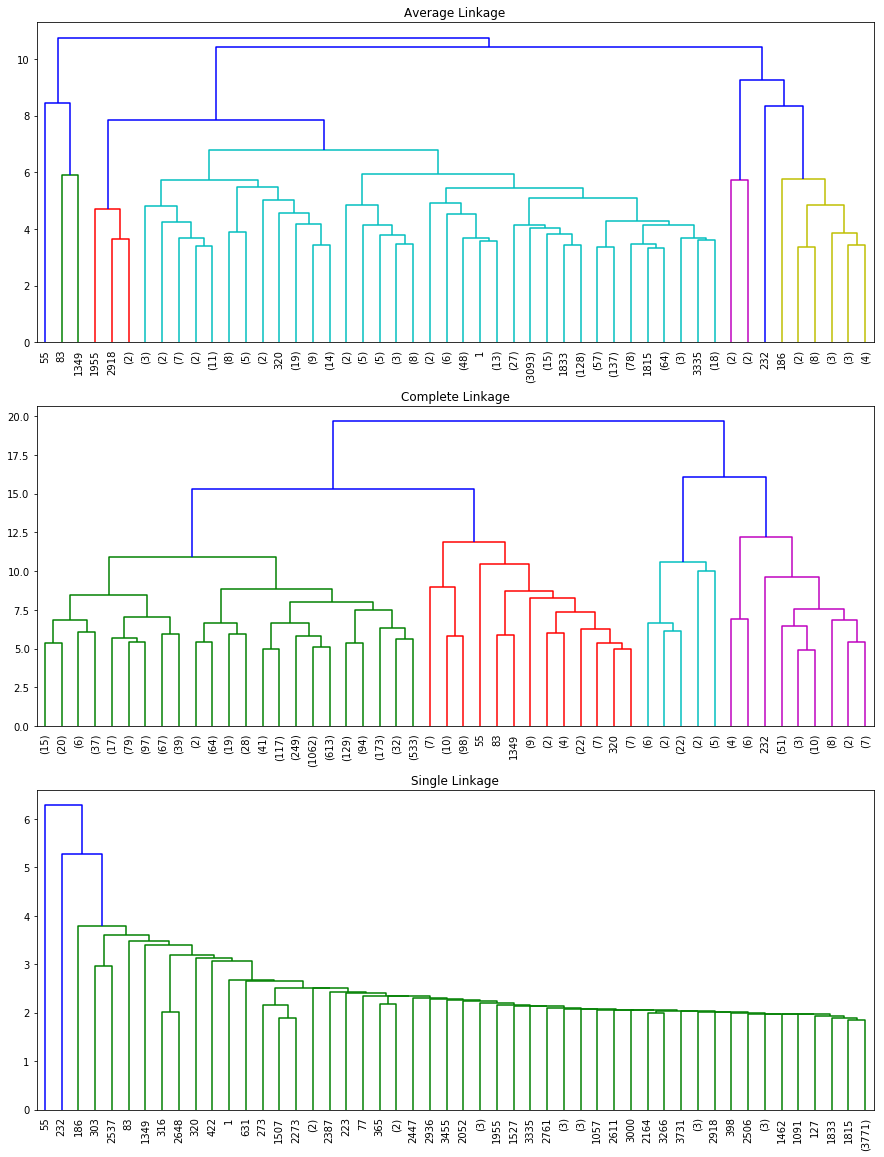

In [10]:
Z1 = linkage(df4,method='average')
Z2 = linkage(df4,method='complete')
Z3 = linkage(df4,method='single')

f, ax = plt.subplots(3,1,figsize=(15, 20))
ax[0].set_title("Average Linkage")
ax[1].set_title("Complete Linkage")
ax[2].set_title("Single Linkage")
dendrogram(Z1,truncate_mode='lastp',p=50,ax=ax[0],leaf_font_size=10)
dendrogram(Z2,truncate_mode='lastp',p=50,ax=ax[1],leaf_font_size=10)
dendrogram(Z3,truncate_mode='lastp',p=50,ax=ax[2],leaf_font_size=10)
plt.show()

<span style="color:#003366"><b> Single linkage only requires the closest neighbours between two cluster to be similar for merging and does not consider other points in the cluster. This might result in high variance of points within cluster (not compact). Complete linkage only requires the further neighbours between to be dissimilar for not merging and does not considers other points in cluster. Some data points in the cluster may be closer to data points in other clusters than other points in the same cluster (not distinct). Average linkage has higher computation cost (needs to compute similarity score for every pair of points between two cluster).

### To improve the clustering:

<span style="color:#003366"><b> 1. Assign specific weights to each feature based on domain knowledge to capture the 'dissimilarity' that needed to be measured more accurately
    
<span style="color:#003366"><b> 2. Feature scaling for proper calculation of distance metrics for dissimiliarity measure. Without feature scaling, features with different scale or order of magnitude can overweigh/underweight its importance in the dissimiliarity calculation. <span style="color:red">(Implemented)

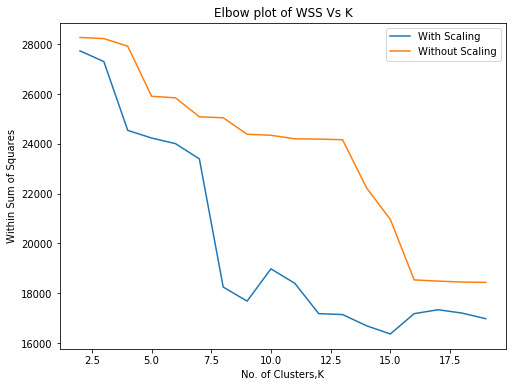

In [38]:
#elbow method for complete linkage clustering
df4b =  pd.DataFrame(copy.deepcopy(df4),columns = df2.columns)
df3b =  pd.DataFrame(copy.deepcopy(df3),columns = df2.columns)
sse_list = []
sse_list2 = []

for k in range(2,20):
    sse_k = []
    sse_k2 = []
    
    for seed in [1,7,42,123,456,111,222,333,444,555]:
        Z2b = linkage(df4b,method='complete')
        df4b['Cluster'] = fcluster(Z2b, k, criterion='maxclust')
        centroid = df4b.groupby('Cluster').mean().values
        SSE = []
        for n in np.unique(df4b['Cluster']-1):
            SSE.append(np.sum([np.linalg.norm(df4[i,]-centroid[n,])**2 for i in np.where((df4b['Cluster']-1) ==n)[0]]))
        sse_k.append(np.sum(SSE))
        
        Z2c = linkage(df3,method='complete')
        df4b['Cluster'] = fcluster(Z2c, k, criterion='maxclust') # Use non-scaled clusters on scaled data to get comparable WSS
        centroid = df4b.groupby('Cluster').mean().values
        SSE = []
        for n in np.unique(df4b['Cluster']-1):
            SSE.append(np.sum([np.linalg.norm(df4[i,]-centroid[n,])**2 for i in np.where((df4b['Cluster']-1) ==n)[0]]))
        sse_k2.append(np.sum(SSE))
        
    sse_list.append(np.mean(sse_k))
    sse_list2.append(np.mean(sse_k2))
    
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(list(range(2,20)),sse_list,label='With Scaling')
plt.plot(list(range(2,20)),sse_list2,label='Without Scaling')
ax.set_title('Elbow plot of WSS Vs K')
x_axis = plt.xlabel('No. of Clusters,K')
y_axis = plt.ylabel('Within Sum of Squares')
plt.legend()
plt.show()   

<span style="color:#003366"><b> Since the within sum of squares plot for the scaled data lies below that for the unscaled data for all K, clustering on the scaled data is better than that on the unscaled data  

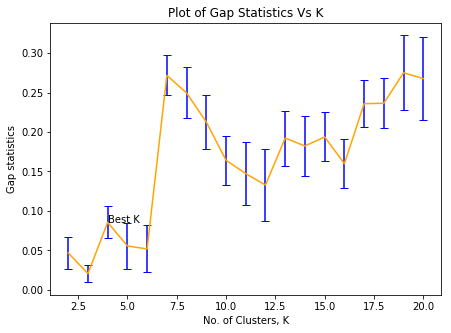

In [12]:
def hclust_optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """

    data_df = pd.DataFrame(data,columns = ['NoOfInvoices', 'NoOfUniqueItems', 'QuantityPerInvoice',
                                           'SpendingPerInvoice', 'TotalQuantity', 'UniqueItemsPerInvoice',
                                           'UnitPriceMean', 'UnitPriceStd'])
    gaps = np.zeros((len(range(2, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(2, maxClusters+1)):

        np.random.seed(1)
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = copy.deepcopy(data)
            for j in range(data.shape[1]):
                np.random.shuffle(randomReference[:,j])
            # Fit to it
            rr_df = pd.DataFrame(randomReference,columns = ['NoOfInvoices', 'NoOfUniqueItems', 'QuantityPerInvoice',
                                                            'SpendingPerInvoice', 'TotalQuantity', 'UniqueItemsPerInvoice',
                                                            'UnitPriceMean', 'UnitPriceStd'])
            Z2b = linkage(randomReference,method='complete')
            rr_df['Cluster'] = fcluster(Z2b, k, criterion='maxclust')
            centroid = rr_df.groupby('Cluster').mean().values
            SSE = []
            for n in np.unique(rr_df['Cluster']-1):
                SSE.append(np.sum([np.linalg.norm(randomReference[i,]-centroid[n,])**2 for i in np.where((rr_df['Cluster']-1) ==n)[0]]))
           
            refDisp = np.sum(SSE)
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        Z2b = linkage(data,method='complete')
        data_df['Cluster'] = fcluster(Z2b, k, criterion='maxclust')
        centroid = data_df.groupby('Cluster').mean().values
        SSE = []
        for n in np.unique(data_df['Cluster']-1):
            SSE.append(np.sum([np.linalg.norm(data[i,]-centroid[n,])**2 for i in np.where((data_df['Cluster']-1) ==n)[0]]))

        origDisp = np.sum(SSE)

        # Calculate gap statistic
        gap = np.mean(np.log(refDisps)- np.log(origDisp))
        gap_sd = np.std(np.log(refDisps)- np.log(origDisp))

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap,'gap_sd':gap_sd}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

k, gapdf = hclust_optimalK(df4, nrefs=10, maxClusters=20)

gapdf2 = gapdf.iloc[:,:]
f, ax = plt.subplots(figsize=(7, 5))
plt.errorbar(gapdf2['clusterCount'],gapdf2['gap'], yerr=gapdf2['gap_sd'], capsize=4,color = 'orange',ecolor='blue')
ax.set_title('Plot of Gap Statistics Vs K')
x_axis = plt.xlabel('No. of Clusters, K')
y_axis = plt.ylabel('Gap statistics')
ax.annotate('Best K', (gapdf2['clusterCount'][2],gapdf2['gap'][2]))
plt.show() 
 

In [13]:
k=4
df3['Cluster'] = fcluster(Z2, k, criterion='maxclust')

### Customer Segment Description

In [14]:
df3.groupby('Cluster').mean()

,NoOfInvoices,NoOfUniqueItems,QuantityPerInvoice,SpendingPerInvoice,TotalQuantity,UniqueItemsPerInvoice,UnitPriceMean,UnitPriceStd
Cluster,,,,,,,,
1,3.433626,48.534673,176.271277,302.096577,63.127937,15.861726,3.152440,2.816499
2,2.247059,53.200000,643.528100,1003.819411,64.082353,32.048097,2.689092,2.694227
3,2.297297,10.081081,71.935435,260.912676,13.135135,5.658408,11.874506,13.553027
4,3.423913,49.869565,216.483299,425.831891,58.434783,17.668202,6.003949,16.452604


<span style="color:#003366"><b> 

<span style="color:#003366"><b> 

<span style="color:#003366"><b>  

<span style="color:#003366"><b> 

In [15]:
sum1 = pd.DataFrame(np.zeros(df3.groupby('Cluster').mean().shape),columns = df3.groupby('Cluster').mean().columns, index = df3.groupby('Cluster').mean().index)
for i in range(df3.groupby('Cluster').mean().shape[0]):
    for j in range(df3.groupby('Cluster').mean().shape[1]):
        var = df3.columns[j] 
        if (ttest(df3.loc[df3['Cluster']==i+1,var],df3.loc[:,var],equal_var=False)[1] <0.001) and (df3.loc[df3['Cluster']==i+1,var].mean() > df3.loc[:,var].mean()):
            sum1.iloc[i,j] = 'High'
        elif (ttest(df3.loc[df3['Cluster']==i+1,var],df3.loc[:,var],equal_var=False)[1] <0.001) and (df3.loc[df3['Cluster']==i+1,var].mean() < df3.loc[:,var].mean()):
            sum1.iloc[i,j] = 'Low'
        else:
            sum1.iloc[i,j] = 'Average'
sum1

,NoOfInvoices,NoOfUniqueItems,QuantityPerInvoice,SpendingPerInvoice,TotalQuantity,UniqueItemsPerInvoice,UnitPriceMean,UnitPriceStd
Cluster,,,,,,,,
1,Average,Average,Low,Low,Average,Average,Low,Low
2,Low,Average,High,High,Average,High,Low,Low
3,Average,Low,Low,Average,Low,Low,High,High
4,Average,Average,Average,High,Average,Average,High,High


### K-means and GMM Clustering iteration #1 [reference pg 509](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)
Apart from hierarchical clustering, we can also apply KMeans and Gaussian Mixture Models (GMM) on the data

1. Implement K-means clustering on the data, experimenting with different values of k 
2. Implement a Gaussian Mixture Model on the data, experimenting with different values for the number of components.  
3. Visualise how well K-means and GMMs succeed at separating subgroups in the data
4. List two ways to improve the clustering and implement at least one. 
5. Describe the clusters and evaluate whether or not they form meaningful segments. 

In [16]:
df6 = df3.iloc[:,:-1]
df6 = scaler.fit_transform(df6.values)

### K Means

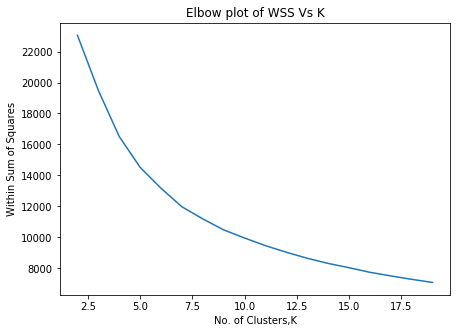

In [16]:
#Kmeans
sse_list = []

for k in range(2,20):
    sse_k = []
    
    for seed in [1,7,42,123,456,111,222,333,444,555]:
        kmean = KMeans(n_clusters=k, random_state=seed)
        cluster_labels = kmean.fit_predict(df6)
        sse_score = kmean.inertia_

        sse_k.append(sse_score)
        
    sse_list.append(np.mean(sse_k))
    
f, ax = plt.subplots(figsize=(7, 5))
fig = plt.plot(list(range(2,20)),sse_list)
ax.set_title('Elbow plot of WSS Vs K')
x_axis = plt.xlabel('No. of Clusters,K')
y_axis = plt.ylabel('Within Sum of Squares')
plt.show()    

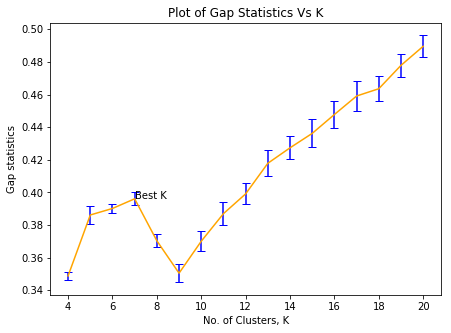

In [19]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters+1)):

        np.random.seed(1)
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = copy.deepcopy(data)
            for j in range(data.shape[1]):
                np.random.shuffle(randomReference[:,j])
            # Fit to it
            km = KMeans(k,random_state = 42)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k,random_state = 42)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.mean(np.log(refDisps)- np.log(origDisp))
        gap_sd = np.std(np.log(refDisps)- np.log(origDisp))

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap,'gap_sd':gap_sd}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

k, gapdf = optimalK(df6, nrefs=10, maxClusters=20)

gapdf2 = gapdf.iloc[3:,:]
f, ax = plt.subplots(figsize=(7, 5))
plt.errorbar(gapdf2['clusterCount'],gapdf2['gap'], yerr=gapdf2['gap_sd'], capsize=4,color = 'orange',ecolor='blue')
ax.set_title('Plot of Gap Statistics Vs K')
x_axis = plt.xlabel('No. of Clusters, K')
y_axis = plt.ylabel('Gap statistics')
ax.annotate('Best K', (gapdf2['clusterCount'][6],gapdf2['gap'][6]))
plt.show() 
 


### Gaussian Mixture Model

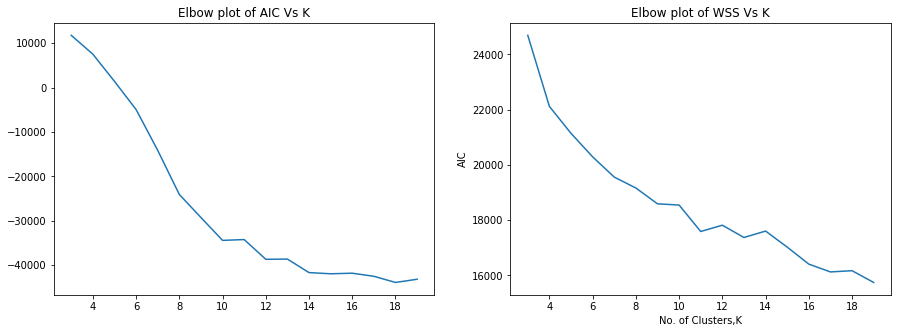

In [19]:
aic_list = []
SSW_list =[]

for k in range(3,20):
    aic_k=[]
    SSW_k=[]
    for seed in [1,7,42,123,456,111,222,333,444,555]:
        gmm = GaussianMixture(n_components=k, random_state=seed)
        labels = gmm.fit_predict(df6)
        
        centroid = gmm.means_
        SSE = []
        for n in np.unique(labels):
            SSE.append(np.sum([np.linalg.norm(df6[i,]-centroid[n,])**2 for i in np.where((labels) ==n)[0]]))
        
        aic_score = gmm.aic(df6)
        
        aic_k.append(aic_score)
        SSW_k.append(np.sum(SSE))
        
    aic_list.append(np.mean(aic_k))
    SSW_list.append(np.mean(SSW_k))
    
f, ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].plot(list(range(3,20)),aic_list)
ax[1].plot(list(range(3,20)),SSW_list)

ax[0].set_title('Elbow plot of AIC Vs K')
ax[1].set_title('Elbow plot of WSS Vs K')

x_axis = plt.xlabel('No. of Clusters,K')
y_axis = plt.ylabel('AIC')
plt.show()       

<span style="color:#003366"><b> AIC would have been a good metric to evaluate probabilistic soft clusters but since we are taking the clusters as hard clusters, within-cluster sum of squares would be a better metric. By using WSS instead of AIC, the optimal number of clusters is reduced (5 vs 10 for AIC). As GMM are able to model overlapping probability densities,  significant overlap betweeen the clusters could be observed if an excessively high K is specified for GMM (see below in PCA section).

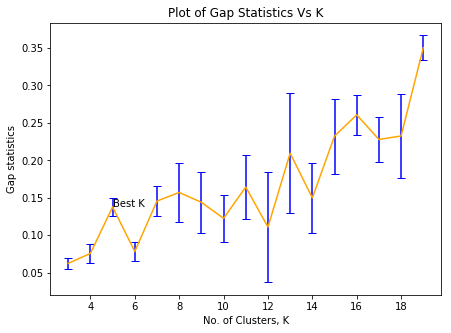

In [20]:
def gmm_optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        np.random.seed(1)
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = copy.deepcopy(data)
            for j in range(data.shape[1]):
                np.random.shuffle(randomReference[:,j])
            # Fit to it
            gmm = GaussianMixture(n_components=k, random_state=1)           
            labels = gmm.fit_predict(randomReference)
        
            centroid = gmm.means_
            SSE = []
            for n in np.unique(labels):
                SSE.append(np.sum([np.linalg.norm(randomReference[i,]-centroid[n,])**2 for i in np.where((labels) ==n)[0]]))   
            
            refDisp = np.sum(SSE)
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        gmm = GaussianMixture(n_components=k, random_state=1)
        labels = gmm.fit_predict(data)
        
        centroid = gmm.means_
        SSE = []
        for n in np.unique(labels):
            SSE.append(np.sum([np.linalg.norm(data[i,]-centroid[n,])**2 for i in np.where((labels) ==n)[0]]))                                             
                           
        origDisp = np.sum(SSE)

        # Calculate gap statistic
        gap = np.mean(np.log(refDisps)- np.log(origDisp))
        gap_sd = np.std(np.log(refDisps)- np.log(origDisp))

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap, 'gap_std':gap_sd}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

k, gapdf = gmm_optimalK(df6, nrefs=10, maxClusters=20)

gapdf2 = gapdf.iloc[2:,:]
f, ax = plt.subplots(figsize=(7, 5))
plt.errorbar(gapdf2['clusterCount'],gapdf2['gap'], yerr=gapdf2['gap_std'], capsize=4,color = 'orange',ecolor='blue')
ax.set_title('Plot of Gap Statistics Vs K')
x_axis = plt.xlabel('No. of Clusters, K')
y_axis = plt.ylabel('Gap statistics')
ax.annotate('Best K', (gapdf2['clusterCount'][4],gapdf2['gap'][4]))
plt.show()   

### Visualize Subgroups

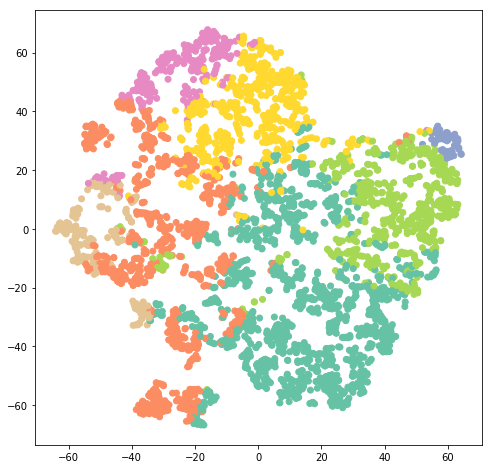

In [56]:
#t-sne transformation
X_embedded = TSNE(n_components=2,random_state=1).fit_transform(df6)

#Best Clustering by K means
kmean = KMeans(n_clusters=7, random_state=42)
k_cluster = kmean.fit_predict(df6)

import seaborn as sns
color_labels = np.unique(k_cluster)

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
f, ax = plt.subplots(figsize=(8, 8))
fig0 = plt.scatter(X_embedded[:,0],X_embedded[:,1], c=pd.Series(k_cluster).map(color_map))
plt.show()

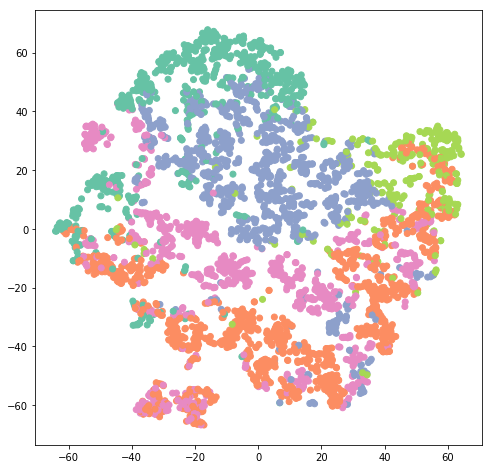

In [57]:
#t-sne transformation
X_embedded = TSNE(n_components=2,random_state=1).fit_transform(df6)

#Best Clustering by Gaussian Mixture Model
gmm = GaussianMixture(n_components=5, random_state=1)
gmm_cluster = gmm.fit_predict(df6)

color_labels = np.unique(gmm_cluster)

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
f, ax = plt.subplots(figsize=(8, 8))
fig = plt.scatter(X_embedded[:,0],X_embedded[:,1], c=pd.Series(gmm_cluster).map(color_map))

### To improve the clustering:

<span style="color:#003366"><b> 1. Assign specific weights to each feature based on domain knowledge to capture the 'dissimilarity' that needed to be measured more accurately
    
<span style="color:#003366"><b> 2. Feature scaling for proper calculation of distance metrics for dissimiliarity measure. Without feature scaling, features with different scale or order of magnitude can overweigh/underweight its importance in the dissimiliarity calculation. <span style="color:red">(Implemented)

### Customer Segments Description

In [64]:
df3['Cluster'] = k_cluster
df3.groupby('Cluster').mean()

,NoOfInvoices,NoOfUniqueItems,QuantityPerInvoice,SpendingPerInvoice,TotalQuantity,UniqueItemsPerInvoice,UnitPriceMean,UnitPriceStd
Cluster,,,,,,,,
0,2.110106,19.861991,139.158276,215.388774,22.785822,10.367552,2.567825,2.084419
1,1.998805,55.384707,241.213461,385.250693,61.278375,29.265034,2.813932,2.746538
2,3.777778,39.685185,173.738198,385.859602,48.203704,12.167549,9.935143,23.032234
3,8.175373,167.447761,251.902323,433.979713,247.973881,25.085250,2.935510,3.209582
4,2.178396,19.779051,91.908944,255.265112,22.543372,10.410129,5.442031,5.088126
5,7.780669,79.676580,192.922821,328.651285,114.840149,11.729266,3.078213,3.024135
6,2.676768,54.616162,664.061638,1054.556101,69.015152,25.401278,2.635679,2.632720


In [65]:
sum2 = pd.DataFrame(np.zeros(df3.groupby('Cluster').mean().shape),columns = df3.groupby('Cluster').mean().columns, index = df3.groupby('Cluster').mean().index)
for i in range(df3.groupby('Cluster').mean().shape[0]):
    for j in range(df3.groupby('Cluster').mean().shape[1]):
        var = df3.columns[j] 
        if (ttest(df3.loc[df3['Cluster']==i,var],df3.loc[:,var],equal_var=False)[1] <0.001) and (df3.loc[df3['Cluster']==i,var].mean() > df3.loc[:,var].mean()):
            sum2.iloc[i,j] = 'High'
        elif (ttest(df3.loc[df3['Cluster']==i,var],df3.loc[:,var],equal_var=False)[1] <0.001) and (df3.loc[df3['Cluster']==i,var].mean() < df3.loc[:,var].mean()):
            sum2.iloc[i,j] = 'Low'
        else:
            sum2.iloc[i,j] = 'Average'
sum2

,NoOfInvoices,NoOfUniqueItems,QuantityPerInvoice,SpendingPerInvoice,TotalQuantity,UniqueItemsPerInvoice,UnitPriceMean,UnitPriceStd
Cluster,,,,,,,,
0,Low,Low,Low,Low,Low,Low,Low,Low
1,Low,High,High,High,Average,High,Low,Low
2,Average,Average,Average,Average,Average,Average,High,High
3,High,High,High,High,High,High,Low,Average
4,Low,Low,Low,Low,Low,Low,High,High
5,High,High,Average,Average,High,Low,Low,Average
6,Low,Average,High,High,Average,High,Low,Low


In [66]:
df3['Cluster'] = gmm_cluster
#df3.to_csv('data/derived/gmm.csv',index=True)
df3.groupby('Cluster').mean()

,NoOfInvoices,NoOfUniqueItems,QuantityPerInvoice,SpendingPerInvoice,TotalQuantity,UniqueItemsPerInvoice,UnitPriceMean,UnitPriceStd
Cluster,,,,,,,,
0,7.754358,110.561014,333.516510,537.347292,167.407290,18.825866,2.904039,2.964860
1,1.000000,16.582817,180.030115,307.144970,16.582817,16.582817,3.303091,2.872983
2,4.450000,57.789796,166.404495,283.959444,72.177551,13.174861,2.960090,2.693229
3,1.939877,39.312883,175.528630,289.917417,42.531288,20.905930,2.903018,2.571125
4,3.425993,30.028881,126.025691,311.881034,36.223827,10.006030,6.346392,9.294418


In [67]:
sum3 = pd.DataFrame(np.zeros(df3.groupby('Cluster').mean().shape),columns = df3.groupby('Cluster').mean().columns, index = df3.groupby('Cluster').mean().index)
for i in range(df3.groupby('Cluster').mean().shape[0]):
    for j in range(df3.groupby('Cluster').mean().shape[1]):
        var = df3.columns[j] 
        if (ttest(df3.loc[df3['Cluster']==i,var],df3.loc[:,var],equal_var=False)[1] <0.001) and (df3.loc[df3['Cluster']==i,var].mean() > df3.loc[:,var].mean()):
            sum3.iloc[i,j] = 'High'
        elif (ttest(df3.loc[df3['Cluster']==i,var],df3.loc[:,var],equal_var=False)[1] <0.001) and (df3.loc[df3['Cluster']==i,var].mean() < df3.loc[:,var].mean()):
            sum3.iloc[i,j] = 'Low'
        else:
            sum3.iloc[i,j] = 'Average'
sum3

,NoOfInvoices,NoOfUniqueItems,QuantityPerInvoice,SpendingPerInvoice,TotalQuantity,UniqueItemsPerInvoice,UnitPriceMean,UnitPriceStd
Cluster,,,,,,,,
0,High,High,High,High,High,High,Low,Average
1,Low,Low,Low,Low,Low,Average,Average,Low
2,High,High,Low,Low,High,Low,Low,Low
3,Low,Low,Low,Low,Low,High,Low,Low
4,Average,Low,Low,Average,Low,Low,High,High


### Outliers 

1. Do outliers influence the results of your Hierarchical Clustering, K-means and GMM models?  
2. Do the outliers themselves form clusters? 

##### Approach: Introduce 2 known extreme outliers to illustrate the effect of outliers on clustering algorithms

In [26]:
# High Quanity/Invoice and Spending/Invoice

df2.iloc[2966,:]

NoOfInvoices                 2.00000
NoOfUniqueItems              3.00000
QuantityPerInvoice       40498.50000
SpendingPerInvoice       84236.25000
TotalQuantity                3.00000
UniqueItemsPerInvoice        1.50000
UnitPriceMean                1.66000
UnitPriceStd                 0.41509
Name: 16446, dtype: float64

In [27]:
# High no. of invoices, no. of unique items, total quanity
df2.iloc[325,:]

NoOfInvoices              209.000000
NoOfUniqueItems          1768.000000
QuantityPerInvoice        120.990431
SpendingPerInvoice        164.516316
TotalQuantity            4412.000000
UniqueItemsPerInvoice       8.459330
UnitPriceMean               2.751706
UnitPriceStd               14.567402
Name: 12748, dtype: float64

In [26]:
#with outliers
df7 = np.vstack([df4,scaler.transform(np.array(df2.iloc[2966,:]).reshape(1, -1)),scaler.transform(np.array(df2.iloc[323,:]).reshape(1, -1))])
#df7 = np.vstack([df4,np.array(df2.iloc[2966,:]),np.array(df2.iloc[325,:])])
df7.shape

(3834, 8)

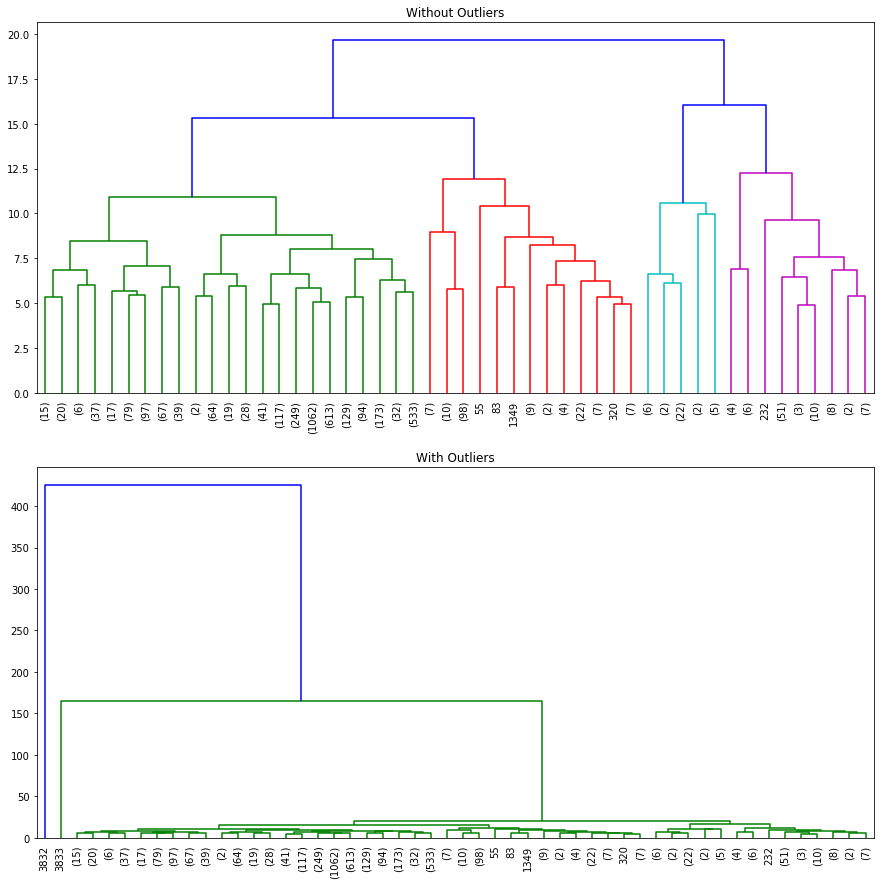

In [29]:
#Hierarchical Clustering
Z7 = linkage(df7,method='complete')

f, ax = plt.subplots(2,1,figsize=(15, 15))
ax[0].set_title("Without Outliers")
ax[1].set_title("With Outliers")
dendrogram(Z2,truncate_mode='lastp',p=50,ax=ax[0],leaf_font_size=10)
dendrogram(Z7,truncate_mode='lastp',p=52,ax=ax[1],leaf_font_size=10)
plt.show()


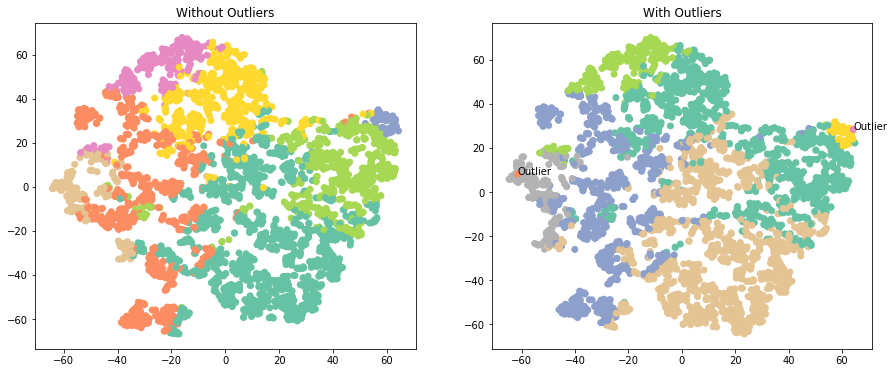

In [30]:
#Kmeans
f, ax = plt.subplots(1,2,figsize=(15, 6))

# Without Outliers
X_embedded = TSNE(n_components=2,random_state=1).fit_transform(df6)

kmean = KMeans(n_clusters=7, random_state=42)
k_cluster = kmean.fit_predict(df6)

color_labels = np.unique(k_cluster)

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

ax[0].scatter(X_embedded[:,0],X_embedded[:,1], c=pd.Series(k_cluster).map(color_map))

#With Outliers
X_embedded = TSNE(n_components=2,random_state=1).fit_transform(df7)

kmean = KMeans(n_clusters=9, random_state=42)
k_cluster = kmean.fit_predict(df7)

color_labels = np.unique(k_cluster)

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
ax[1].scatter(X_embedded[:,0],X_embedded[:,1], c=pd.Series(k_cluster).map(color_map))
ax[1].annotate('Outlier', (X_embedded[3832,0],X_embedded[3832,1]))
ax[1].annotate('Outlier', (X_embedded[3833,0],X_embedded[3833,1]))

ax[0].set_title("Without Outliers")
ax[1].set_title("With Outliers with additional K")
plt.show()


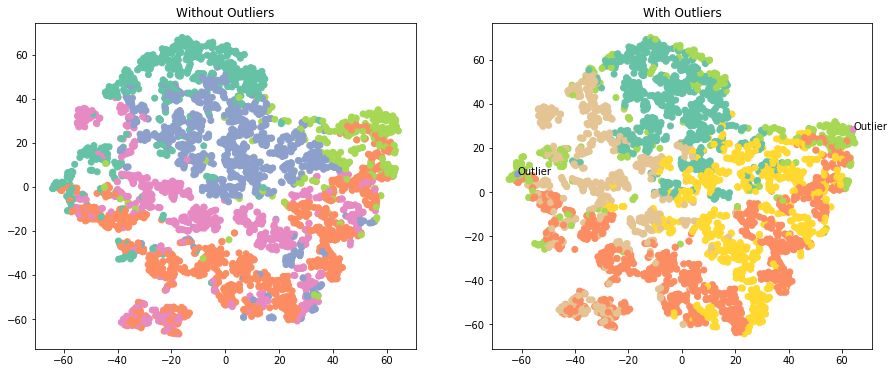

In [31]:
f, ax = plt.subplots(1,2,figsize=(15, 6))

#Without Outliers
X_embedded = TSNE(n_components=2,random_state=1).fit_transform(df6)

gmm = GaussianMixture(n_components=5, random_state=1)
gmm_cluster = gmm.fit_predict(df6)

color_labels = np.unique(gmm_cluster)

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
ax[0].scatter(X_embedded[:,0],X_embedded[:,1], c=pd.Series(gmm_cluster).map(color_map))

#With Outliers
X_embedded = TSNE(n_components=2,random_state=1).fit_transform(df7)

gmm = GaussianMixture(n_components=7, random_state=1)
gmm_cluster = gmm.fit_predict(df7)

color_labels = np.unique(gmm_cluster)

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
ax[1].annotate('Outlier', (X_embedded[3832,0],X_embedded[3832,1]))
ax[1].annotate('Outlier', (X_embedded[3833,0],X_embedded[3833,1]))
ax[1].scatter(X_embedded[:,0],X_embedded[:,1], c=pd.Series(gmm_cluster).map(color_map))

ax[0].set_title("Without Outliers")
ax[1].set_title("With Outliers")
plt.show()

<span style="color:#003366"><b> Outliers form clusters of their own if allowed by the defined number of clusters and if they are very different from the majority of the data points in the dataset. These outliers can also be very different among themselves and form their own clusters. Much more clusters are needed in the clustering to account for these outliers if they are not removed.
    
<span style="color:#003366"><b> When additional clusters are allowed for the outliers, the K means clusters are very similar to  the clusters formed without outlier (robust to outliers) except at regions near the outliers. For GMM models, all the final clusters generated with outliers are very different from the clustering without outliers even though only 2 data points are added to the dataset. This may be due to high dependency between clusters through the covariance matrix.

### Validating clusters  

1. Use at least three techniques to validate that your chosen clusters correspond to meaningful customer segments. You may consider a combination of using visualisations and/or quantitative metrics (refer to Elements of Statistical Learning for some examples)

<span style="color:#003366"><b> 1. Gap Statistics - Comparison of clustering of current data to random data(shuffling the rows in the dataset). Selects the smallest k within one standard error of the local maxima.<br/>
http://web.stanford.edu/~hastie/Papers/gap.pdf<br/>
https://stats.stackexchange.com/questions/95290/how-should-i-interpret-gap-statistic
    
<span style="color:#003366"><b> 2. Elbow plot - Look for 'kink' in the WSS vs K plot. Might be very subjective where the 'kink' is as the plot may not be smooth. Represents a drop in the decrease of the sum of square distance from the centroid within the clusters. 
    
<span style="color:#003366"><b> 3. Using t-sne to project the 8-dimension space to 2-d and observe whether the clustering is well seperated

<span style="color:#003366"><b> 4. Looking through the feature means of the feature set and look for differences between feature means in different clusters with the feature means of the whole data  
    
<span style="color:#003366"><b> 5. Other clustering metrics e.g. sihouette score(combination of WSS and BSS) or calinski-harabaz score(Between-Variance/Within Variance) other than WSS may be possible. <span style="color:red">(Not Implemented)


### Model selection

1. Explain when it is appropriate to use K-Means, GMM and Hierarchical Clustering 
2. Which model would you choose for this dataset? 

<span style="color:#003366"><b> 1. Hierachical clustering imposes a natural hierarchical structure whether such as structure actually exist in the data and is more suitable for data where the data points follow a natrual hierarchy. Result in a fixed dendrogram and the number of clusters can be determined by cutting the dendrogram at a user-defined level.
    
<span style="color:#003366"><b> Kmeans clustering allows only the euclidean distance as the dissimilarity metric for clustering and are suitable for a dataset with numerical variables (Vs k-medoids). It assumes spherical data distribution aligned to feature axes (Vs. Spectral clustering) and is highly dependent on the number of clusters defined (usually defined as part of the businees problem) where cluster assignment can change drastically across different K in an arbitrary manner (method robustness). Squaring in computing euclidean distance makes kmeans cluster highly influenced by outliers. K-mediods which generalizes K means to other distances besides euclidean could make the clustering more robust.
    
https://github.com/letiantian/kmedoids
<br><br>

<span style="color:#003366"><b> Gaussian mixture models assume that the data points in the data set were drawn from a mixture of multivariate normal probability density (n_components = number of mixtures). The mean of each probability density corresponds to the centroid of one cluster. As the probability densities can overlap (data points having significant probability of being drawn from more than one probability density), gaussian mixture models gives soft clustering which allows a certain probability for a data point to belong to a cluster. Both hierarchical clustering and kmeans clustering gives hard clusters where a data point either belong or do not belong in one cluster. Hence, gmm models gives more information regarding the degree of how well each data point belong to a cluster. Depending on the probability cutoff, a datapoint can belong to multiple cluster or no cluster(outlier?). Unlike K means clustering, elliptical clusters with arbitrary orientation can be formed by allowing maximum freedom in the variance-covariance matrix of the multivariate probability density. 
    
http://www.aishack.in/tutorials/expectation-maximization-gaussian-mixture-model-mixtures/

##### Analagous greedy iterative algorithm between Kmeans algorithm Vs GMM EM algorithm:
Initialization
- Kmeans: Random data points as centroid
- GMM: Initial guess for mean,covariance,weightage. Sklearn default uses kmeans for the inital guess.

Iterative Step 1: Assign data points to cluster
- Kmeans: Assign data points to nearest centroid
- Expectation: Calculate probability that data point comes from a given gaussian probability density

Iterative Step 2: Updata parameters
- Kmeans: Calculate new centroid
- Maximization: Given observed data points, update mean, covariance, weightage parameters to maximize probability of observing those data (max likelihood)


<span style="color:#003366"><b> 2. Since the rows of the data are customers, the clustering is unlikely to follow a natural hierarchy. Soft clustering may not be required in this example and since GMM is meant to model overlapping probability densities, hard clusters formed by this method may not be optimal.  As all the features in the dataset were continuous numerical variable, euclidean distance used in K means clustering is the natural dissimilarity metric. Outliers removal and standard scaling tends to keep the distribution of the data points spherical. These reasons made kmeans clustering suitable for use on this pre-processed dataset. 
    
<span style="color:#003366"><b> To obtain the best K, an elbow plot or a pre-defined K as part of the business problem could be used. In support of these reasons, the t-sne plots show that kmeans performed better than GMM with regards to getting well-seperated clusters. Furthermore, the gap statistics for Kmeans at ~0.4 is better than that of GMM at ~0.15, indicating that Kmeans is able to cluster better than GMM on this data with respect to noise.

### Opening the black box of clustering [reference pg 503](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)

1. In your own words, explain the broad idea behind building a proximity matrix to cluster data. (This should also be verbally presented during Monday's presentation). 
*Sometimes, typing values into MS Excel helps with building intuition

<span style="color:#003366"><b> The promxity matrix is an mxm matrix, M where m is the number of objects in the dataset. The pairwise dissimilarity between object i and object j is record in M(i,j) of the matrix. The diagonal of the matrix represents the dissimilarity between the same object which is 0. Also, since M(i,j) and M(j,i) represents dissimilarity between the same two objects, the matrix is symmetrical. The proximity matrix gives a convenient way to store dissimilar values between objects and this dissimilar values will be used by clustering algorithm to group objects that are similar relative to other objects together.

2. In your own words, how would you calculate the disimilarity between objects in a dataset? (This should also be verbally presented during Monday's presentation)

<span style="color:#003366"><b> Taking the current dataset with 8 features as an example, the data points lie in an 8-dimension plots. Using euclidean distance as the metric, the pairwise dissimilarity between objects can be seen as the distance between the two object in the 8-dimension plot. Objects that are more similar have a smaller distance between them and tend to belong in the same cluster compared to objects that lies far away. Dissmilarity score chosen depends on the data type of the features. For categorical features, using Hamming distance may be more suitable. For string features in genomic/text data, Levenshtein(edit) distance or Jaro-Winkler distance may be suitable. 

### PCA for Dimensionality Reduction 

1. Using the dataset that you have pre-processed, construct a pairplot again. How is it different from the a plot of the raw data and what is your interpretation?  
2. Apply PCA pre-processed dataset. More information on PCA here [link]
3. Create a plot of cumulative explained variance and number of components. How does this inform you about the best number of components to select? 
4. Create a plot of PC0 against PC1, coloured by the GMM's predictions on the normalised dataset with outliers removed for n_components =7
5. How do the values of principal components relate to the original dataset

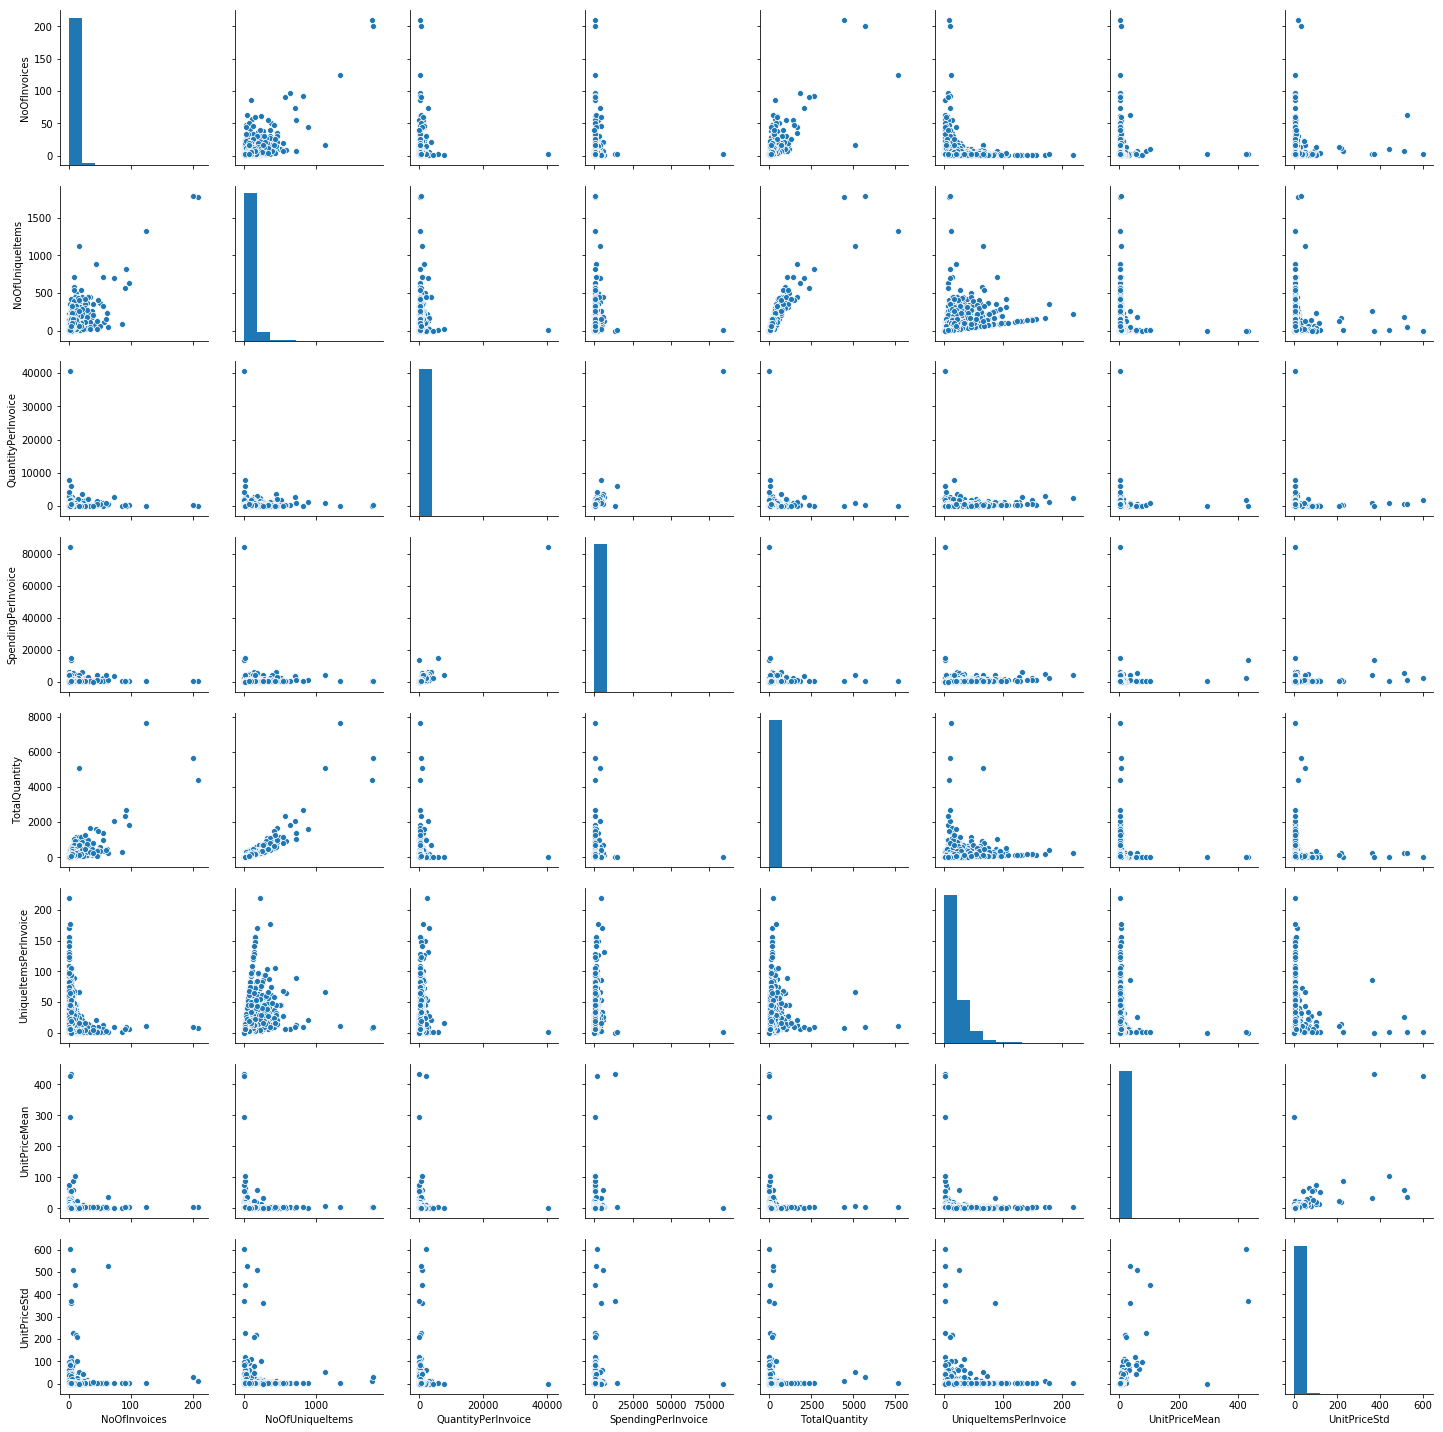

In [32]:
fig = sns.pairplot(df2)

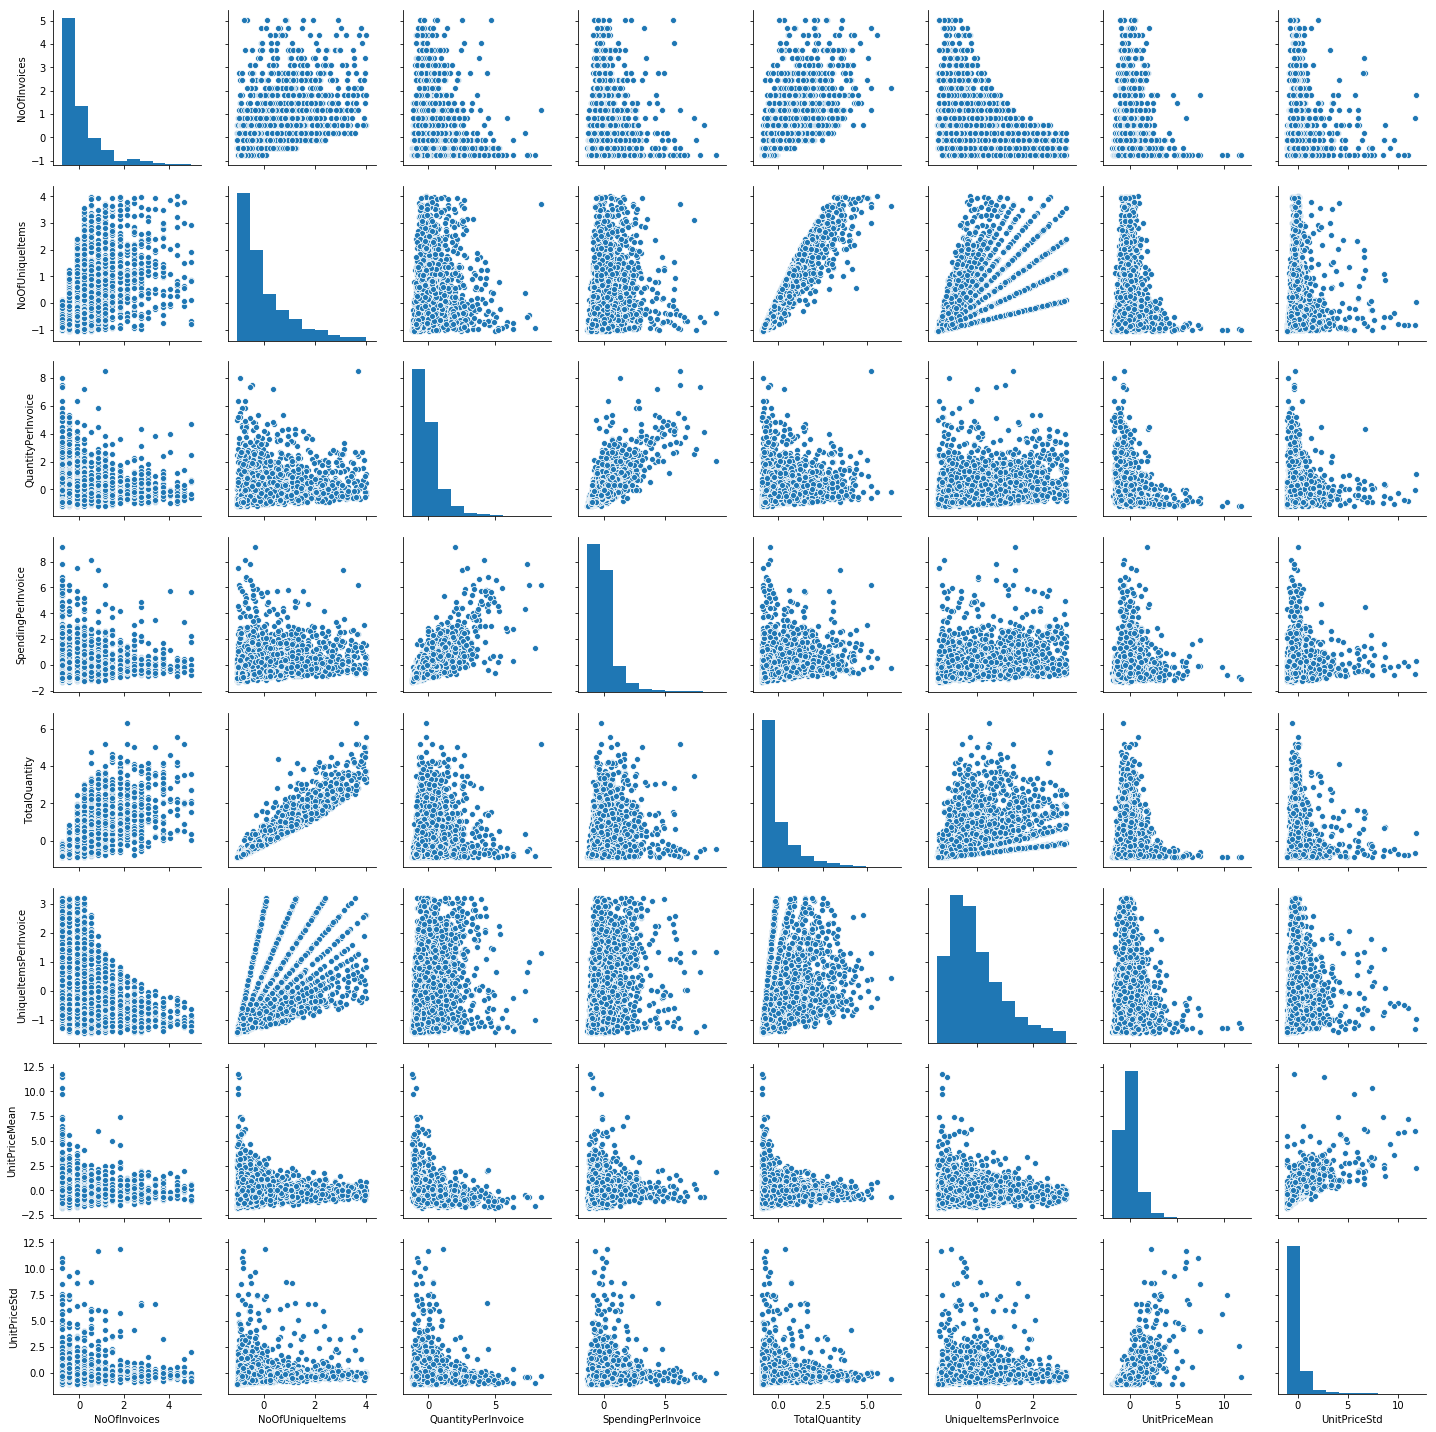

In [33]:
fig = sns.pairplot(pd.DataFrame(df4, columns = df2.columns))

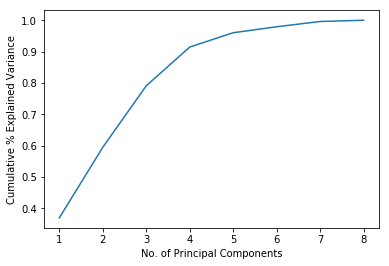

In [34]:
pca = PCA(n_components=8, random_state=1) # max = no. of feature or n-1
pca.fit(df4)

fig = plt.plot(list(range(1,9)),np.cumsum(pca.explained_variance_ratio_))
x_axis = plt.xlabel('No. of Principal Components')
y_axis = plt.ylabel('Cumulative % Explained Variance')

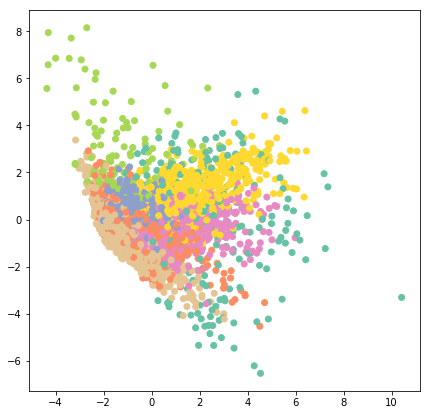

In [35]:
pca = PCA(n_components=8, random_state=1)
pca_x = pca.fit_transform(df4)

gmm = GaussianMixture(n_components=7, random_state=1)
gmm_cluster = gmm.fit_predict(df4)

color_labels = np.unique(gmm_cluster)

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
f, ax = plt.subplots(figsize=(7, 7))
plt.scatter(pca_x[:,0],pca_x[:,1], c=pd.Series(gmm_cluster).map(color_map))
plt.show()

<span style="color:#003366"><b> During PCA, the data points in an 8-dimensional space are projected into a new set of dimensions through linear combinations (with different loading) of the feature values. The direction of the first principle components maximizes the variance of the projected data points ie maximizes information in that direction.  The second princple direction is a feasible orthogonal direction from the first principle direction that again maximizes the variance of the projected data points and so on. Since only variance information is of interest, the values of each feature are centered (mean = 0). Solving a Singular Value Decomposition of the data, the principle direcitons are given by right singular vector (or the eigenvector of the eigendecomposed covariance matrix of the centered data). Since the left singular vector is nxn and the right singular vector is pxp, the maximum number of principle components is max(n, p) where n is the number of data points and p is the number of features. Hence, the original data points could be mapped fully into the a new 8-d space in this case. By projecting the data points in the original 8-d space into a 2-d plane formed by the first 2 principle components, variance of the projected points is maximized ie dispersion of the points is maximized which helps in visualizing the data using a 2-D plot. 
    
https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca?lq=1

Objective: Get eigenvectors (principal directions) from eigendecomposition of the covariance matrix: C=VLV<sup>⊤</sup>, L is a diagonal matrix that give the variances in the principal directions (eigenvalues, in decreasing order)

1. Perform singular value decomposition on data: X=USV<sup>⊤<sup>
2. C=X<sup>⊤</sup>X/(n−1) if X is centered (mean = 0)
3. C= VSU<sup>⊤</sup>USV<sup>⊤</sup>/(n−1)=V(S<sup>2</sup>/n−1)V<sup>⊤</sup>, therefore right singular vector V gives the principle directions
4. XV=USV<sup>⊤</sup>V=US gives principle components (projected X values in principle directions)

### PCA visualization of K means and GMM clustering 

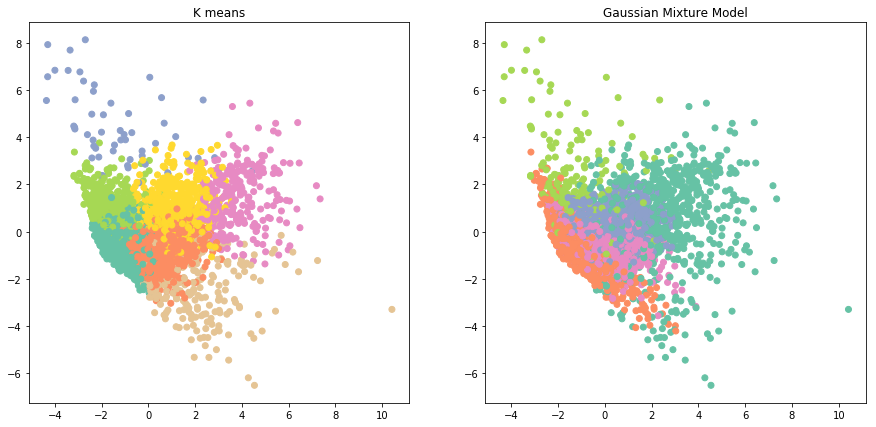

In [36]:
f, ax = plt.subplots(1,2,figsize=(15, 7))

pca = PCA(n_components=8, random_state=1)
pca_x = pca.fit_transform(df4)

kmean = KMeans(n_clusters=7, random_state=42)
k_cluster = kmean.fit_predict(df4)

color_labels = np.unique(k_cluster)

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
ax[0].scatter(pca_x[:,0],pca_x[:,1], c=pd.Series(k_cluster).map(color_map))

gmm = GaussianMixture(n_components=5, random_state=1)
gmm_cluster = gmm.fit_predict(df4)

color_labels = np.unique(gmm_cluster)

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values

ax[1].scatter(pca_x[:,0],pca_x[:,1], c=pd.Series(gmm_cluster).map(color_map))

ax[0].set_title("K means")
ax[1].set_title("Gaussian Mixture Model")
plt.show()

### Selecting the outlier threshold criteria

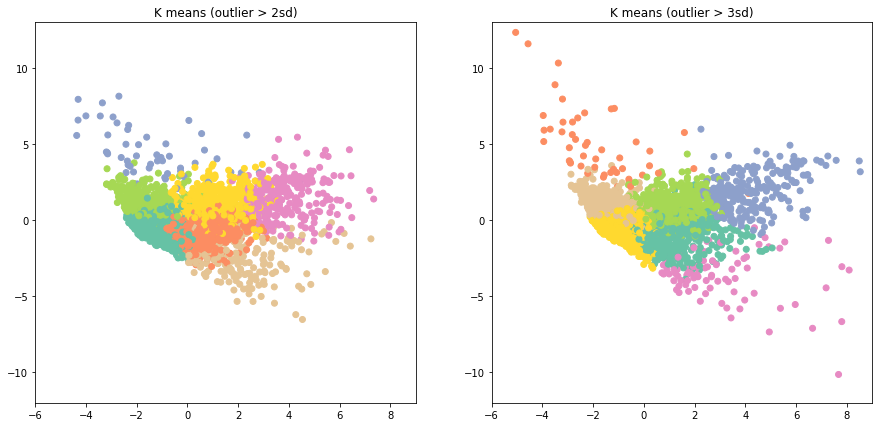

In [37]:
f, ax = plt.subplots(1,2,figsize=(15, 7))

pca = PCA(n_components=8, random_state=1)
pca_x = pca.fit_transform(df4)

kmean = KMeans(n_clusters=7, random_state=42)
k_cluster = kmean.fit_predict(df4)

color_labels = np.unique(k_cluster)

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
ax[0].scatter(pca_x[:,0],pca_x[:,1], c=pd.Series(k_cluster).map(color_map))

df8 = df2
max_val = (np.mean(df2) + 3*np.std(df2)).tolist()
for i in range(df8.shape[1]):
    df8 = df8.loc[df8.iloc[:,i]<=max_val[i],:]

scaler = StandardScaler()
scaler.fit(df8.values)
df8 = scaler.transform(df8.values)
    
pca = PCA(n_components=8, random_state=1)
pca_x = pca.fit_transform(df8)

kmean = KMeans(n_clusters=7, random_state=42)
k_cluster = kmean.fit_predict(df8)

color_labels = np.unique(k_cluster)

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))


# Finally use the mapped values
ax[1].scatter(pca_x[:,0],pca_x[:,1], c=pd.Series(k_cluster).map(color_map))

ax[0].set_title("K means (outlier > 2sd)")
ax[0].set_ylim(-12,13)
ax[0].set_xlim(-6,9)
ax[1].set_title("K means (outlier > 3sd)")
ax[1].set_ylim(-12,13)
ax[1].set_xlim(-6,9)
plt.show()

<span style="color:#003366"><b> Spherical cluster contraints 'pulled' clusters outwards, in the direction towards outliers. Are we really interested in these infrequent data points or are we interested in analyzing clusters formed by majority of the customers?